# Linear Error-in-Variables Mixture Model

Reproduction of examples from section 4 in the original paper; the main aim is to compare the treelet transform with PCA.The task at hand is the recovery of the unobserved structure of the mixture model from a random sample. 

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import sys
import os

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
sys.path.append("../scripts")
import python_treelet_implementation as pytree
import test_treelets_mixture_models as ttmm
import utils

## Model setup

The paper considers a sample $\left \{ \vec{x}_i,y_i \right \}_{i=1}^{n}$ where each multivariate observation $\vec{x} \in \mathbb{R}^p$ has the form $\vec{x} = \sum_{i=}^{K}u_j \vec{v}_j + \sigma \vec{z}$ and each component corresponds to:

* factors: $\left ( u_1, ... u_k \right )^T \sim F_{u_1,...,u_K}$
* loading vectors: $\vec{v}_j$ 
* noise: $\vec{z} \sim \mathcal{N}_p\left ( 0, I \right )$

The response variable has the form $y = \sum_{i=1}^{K}\alpha_j u_j + \epsilon$, where: 

* factor weights: $\alpha_j$ 
* noise: $\epsilon \sim \text{i.i.d}\left ( 0, \sigma_\epsilon^2 \right )$ 

## Uncorrelated factors and non-overlapping loading vectors 

Data is simulated according to example 1 and re-scaled to have mean 0 and variance 1. 

In [27]:
X = ttmm.linear_mixture_model(V = np.array([[1,1,1,0,0,0,0,0,0],
                                            [0,0,0,1,1,1,1,0,0],
                                            [0,0,0,0,0,0,0,1,1]])\
                                    .transpose(),
                         C = 2*np.identity(3), 
                         sigma = 0, 
                         n = 100)

In [28]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Sample covaraince matrix exhibits block structure as required and expected. 

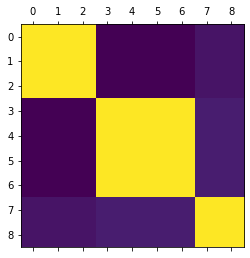

In [29]:
plt.matshow(np.cov(X.transpose()))

Performing PCA and examining the absolute loadings for the first three components the factor structure is apparent. 

In [30]:
pca = PCA(n_components=3)
pca.fit(X)
loadings = np.abs(pca.components_.T * np.sqrt(pca.explained_variance_))

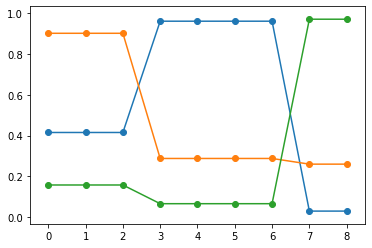

In [31]:
p,l = loadings.shape
for l in range(l): 
    plt.scatter(np.arange(p),loadings[:,l])
    plt.plot(np.arange(p),loadings[:,l])

In [36]:
pytree.treelet_decomposition(X = np.ones(9).reshape(3,3),
                             L = 3)

{0: {'C': array([[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]), 'J': None, 'B': array([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]), 'pair': (None, None), 'order': (None, None)},
 1: {'C': array([[2.        , 0.        , 1.41421356],
         [0.        , 0.        , 0.        ],
         [1.41421356, 0.        , 1.        ]]),
  'J': array([[ 0.70710678, -0.70710678],
         [ 0.70710678,  0.70710678]]),
  'B': array([[ 0.70710678, -0.70710678,  0.        ],
         [ 0.70710678,  0.70710678,  0.        ],
         [ 0.        ,  0.        ,  1.        ]]),
  'pair': (0, 1),
  'order': (1, 0)},
 2: {'C': array([[ 3.00000000e+00,  0.00000000e+00, -2.16362618e-16],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-6.02310394e-17,  0.00000000e+00,  4.25897764e-17]]),
  'J': array([[ 0.81649658, -0.57735027],
         [ 0.57735027,  0.81649658]]),
  'B': array([[ 0.57735027, -0.70710678, -0.40824829],
         [ 0.57735027,  0.70710

In [35]:
1/np.sqrt(2)

0.7071067811865475